#  Prediction of Fuel Efficiency

In [1]:
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import warnings

pd.options.plotting.backend = 'plotly'
warnings.filterwarnings('ignore')

C:\Users\PC\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
auto_df = pd.read_csv('auto-mpg.csv', na_values='?')
auto_df

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0    18.0          8         307.0       130.0    3504          12.0   
1    15.0          8         350.0       165.0    3693          11.5   
2    18.0          8         318.0       150.0    3436          11.0   
3    16.0          8         304.0       150.0    3433          12.0   
4    17.0          8         302.0       140.0    3449          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0    2790          15.6   
394  44.0          4          97.0        52.0    2130          24.6   
395  32.0          4         135.0        84.0    2295          11.6   
396  28.0          4         120.0        79.0    2625          18.6   
397  31.0          4         119.0        82.0    2720          19.4   

     model year  origin                   car name  
0            70       1  chevrolet chevelle malibu  
1            70       1          buick skylark 320  
2            70       1         plymouth satellite  
3            70       1              amc rebel sst  
4            70       1                ford torino  
..          ...     ...                        ...  
393          82       1            ford mustang gl  
394          82       2                  vw pickup  
395          82       1              dodge rampage  
396          82       1                ford ranger  
397          82       1                 chevy s-10  

[398 rows x 9 columns]

In [3]:
auto_df.shape

(398, 9)

In [4]:
auto_df.describe()

mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   75.000000  2223.750000   
50%     23.000000    4.000000    148.500000   93.500000  2803.500000   
75%     29.000000    8.000000    262.000000  126.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration  model year      origin  
count    398.000000  398.000000  398.000000  
mean      15.568090   76.010050    1.572864  
std        2.757689    3.697627    0.802055  
min        8.000000   70.000000    1.000000  
25%       13.825000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.175000   79.000000    2.000000  
max       24.800000   82.000000    3.000000

In [5]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


In [6]:
auto_df.isnull().mean() * 100

mpg             0.000000
cylinders       0.000000
displacement    0.000000
horsepower      1.507538
weight          0.000000
acceleration    0.000000
model year      0.000000
origin          0.000000
car name        0.000000
dtype: float64

In [7]:
auto_df.duplicated().value_counts()

False    398
dtype: int64

In [8]:
auto_df['car name'].value_counts()

ford pinto             6
toyota corolla         5
amc matador            5
ford maverick          5
chevrolet chevette     4
                      ..
chevrolet monza 2+2    1
ford mustang ii        1
pontiac astro          1
amc pacer              1
chevy s-10             1
Name: car name, Length: 305, dtype: int64

In [9]:
auto_df['brand'] = auto_df['car name'].apply(lambda x: x.split()[0])
auto_df['name'] = auto_df['car name'].apply(lambda x: ' '.join(x.split()[1:]))
auto_df.drop(['car name'], axis=1, inplace=True)
auto_df

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0    18.0          8         307.0       130.0    3504          12.0   
1    15.0          8         350.0       165.0    3693          11.5   
2    18.0          8         318.0       150.0    3436          11.0   
3    16.0          8         304.0       150.0    3433          12.0   
4    17.0          8         302.0       140.0    3449          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0    2790          15.6   
394  44.0          4          97.0        52.0    2130          24.6   
395  32.0          4         135.0        84.0    2295          11.6   
396  28.0          4         120.0        79.0    2625          18.6   
397  31.0          4         119.0        82.0    2720          19.4   

     model year  origin      brand             name  
0            70       1  chevrolet  chevelle malibu  
1            70       1      buick      skylark 320  
2            70       1   plymouth        satellite  
3            70       1        amc        rebel sst  
4            70       1       ford           torino  
..          ...     ...        ...              ...  
393          82       1       ford       mustang gl  
394          82       2         vw           pickup  
395          82       1      dodge          rampage  
396          82       1       ford           ranger  
397          82       1      chevy             s-10  

[398 rows x 10 columns]

In [10]:
auto_df.nunique().sort_values(ascending=False)

weight          351
name            300
mpg             129
acceleration     95
horsepower       93
displacement     82
brand            37
model year       13
cylinders         5
origin            3
dtype: int64

In [11]:
auto_df['brand'].value_counts()

ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
chrysler          6
vw                6
volvo             6
renault           5
saab              4
subaru            4
opel              4
chevy             3
bmw               2
cadillac          2
maxda             2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: brand, dtype: int64

## Data Cleaning

In [12]:
def fix_brand_names(brand):
    if brand in ['vw', 'vokswagen']:
        return 'volkswagen'
    elif brand in ['chevy', 'chevroelt']:
        return 'chevrolet'
    elif brand == 'maxda':
        return 'mazda'
    elif brand == 'mercedes':
        return 'mercedes-benz'
    elif brand == 'toyouta':
        return 'toyota'
    else:
        return brand

In [13]:
auto_df['brand'] = auto_df['brand'].apply(lambda x: fix_brand_names(x))
auto_df['brand'].value_counts()

ford             51
chevrolet        47
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
chrysler          6
renault           5
saab              4
opel              4
subaru            4
mercedes-benz     3
cadillac          2
bmw               2
capri             1
hi                1
triumph           1
nissan            1
Name: brand, dtype: int64

In [14]:
auto_df[auto_df['brand'] == 'hi']

mpg  cylinders  displacement  horsepower  weight  acceleration  \
28  9.0          8         304.0       193.0    4732          18.5   

    model year  origin brand   name  
28          70       1    hi  1200d

In [15]:
auto_df.at[28, 'brand'] = 'harvester'
auto_df['brand'].value_counts()

ford             51
chevrolet        47
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
chrysler          6
renault           5
saab              4
opel              4
subaru            4
mercedes-benz     3
cadillac          2
bmw               2
capri             1
harvester         1
triumph           1
nissan            1
Name: brand, dtype: int64

In [16]:
auto_df[auto_df['brand'] == 'capri']

mpg  cylinders  displacement  horsepower  weight  acceleration  \
184  25.0          4         140.0        92.0    2572          14.9   

     model year  origin  brand name  
184          76       1  capri   ii

In [17]:
auto_df.at[184, 'brand'] = 'ford'
auto_df.at[184, 'name'] = 'capri ii'
auto_df['brand'].value_counts()

ford             52
chevrolet        47
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
peugeot           8
fiat              8
audi              7
chrysler          6
volvo             6
renault           5
subaru            4
opel              4
saab              4
mercedes-benz     3
bmw               2
cadillac          2
triumph           1
harvester         1
nissan            1
Name: brand, dtype: int64

## Exploratory Data Analysis

### Categorical Variables

In [18]:
auto_df[['cylinders']].plot.hist()

In [19]:
auto_df[['origin']].plot.hist()

### Numerical Variables

In [20]:
def plot_box_hist(df, name):
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(
        go.Box(
            y=df[name],
            name=name,
            showlegend=False
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Histogram(
            x=df[name],
            name=name,
            showlegend=False
        ),
        row=1, col=2
    )

    fig.update_layout(title_text=name)
    fig.show()

In [21]:
plot_box_hist(auto_df, 'mpg')

In [22]:
plot_box_hist(auto_df, 'displacement')

In [23]:
plot_box_hist(auto_df, 'horsepower')

In [24]:
plot_box_hist(auto_df, 'weight')

In [25]:
plot_box_hist(auto_df, 'acceleration')

In [26]:
plot_box_hist(auto_df, 'model year')

In [27]:
def plot_h_bar(df, x, y, color):
    return px.bar(
            df.sort_values(x, ascending=False)[:10],
            x=x,
            y=y,
            text=x,
            color=color
        ).update_layout(
            yaxis={'categoryorder': 'total ascending'}
        )

### Top 10 Vehicles with Highest MPG

In [28]:
plot_h_bar(auto_df, 'mpg', 'name', 'brand')

### Top 10 Vehicles with Highest Displacement

In [29]:
plot_h_bar(auto_df, 'displacement', 'name', 'brand')

### Top 10 Vehicles with Highest Horsepower

In [30]:
plot_h_bar(auto_df, 'horsepower', 'name', 'brand')

### Top 10 Vehicles with Highest Weight

In [31]:
plot_h_bar(auto_df, 'weight', 'name', 'brand')

### MPG vs. Weight vs. Horsepower

In [32]:
px.scatter(auto_df, x='horsepower', y='mpg', color='weight')

### Scatterplot Matrix

In [33]:
px.scatter_matrix(
    auto_df,
    dimensions=['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year'],
    color='cylinders'
).update_layout(width=1000, height=1000)

In [34]:
px.scatter_matrix(
    auto_df,
    dimensions=['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year'],
    color='origin'
).update_layout(width=1000, height=1000)

### Correlation Heatmap

In [35]:
px.imshow(auto_df.corr(), color_continuous_scale='RdBu', text_auto=True).update_layout(width=950, height=950)

## Replace Null Values in horsepower

In [36]:
auto_df.groupby(['cylinders', 'origin']).agg({'horsepower': ['mean', 'median']})

horsepower       
                        mean median
cylinders origin                   
3         3        99.250000   98.5
4         1        80.956522   84.0
          2        78.311475   76.0
          3        75.579710   70.0
5         2        82.333333   77.0
6         1        99.671233  100.0
          2       113.500000  122.5
          3       115.833333  118.0
8         1       158.300971  150.0

In [37]:
auto_df['horsepower'] = auto_df['horsepower'].fillna(auto_df.groupby(['cylinders', 'origin'])['horsepower'].transform('median'))
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   brand         398 non-null    object 
 9   name          398 non-null    object 
dtypes: float64(4), int64(4), object(2)
memory usage: 31.2+ KB


## Feature Engineering

### mpg

In [38]:
def plot_distplot(df, name):
    mu, std = norm.fit(auto_df['mpg'])

    plt.figure(figsize=(16, 12))
    sns.histplot(df[name], stat='density', kde=True)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.xlabel(name, fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()
    
    return mu, std

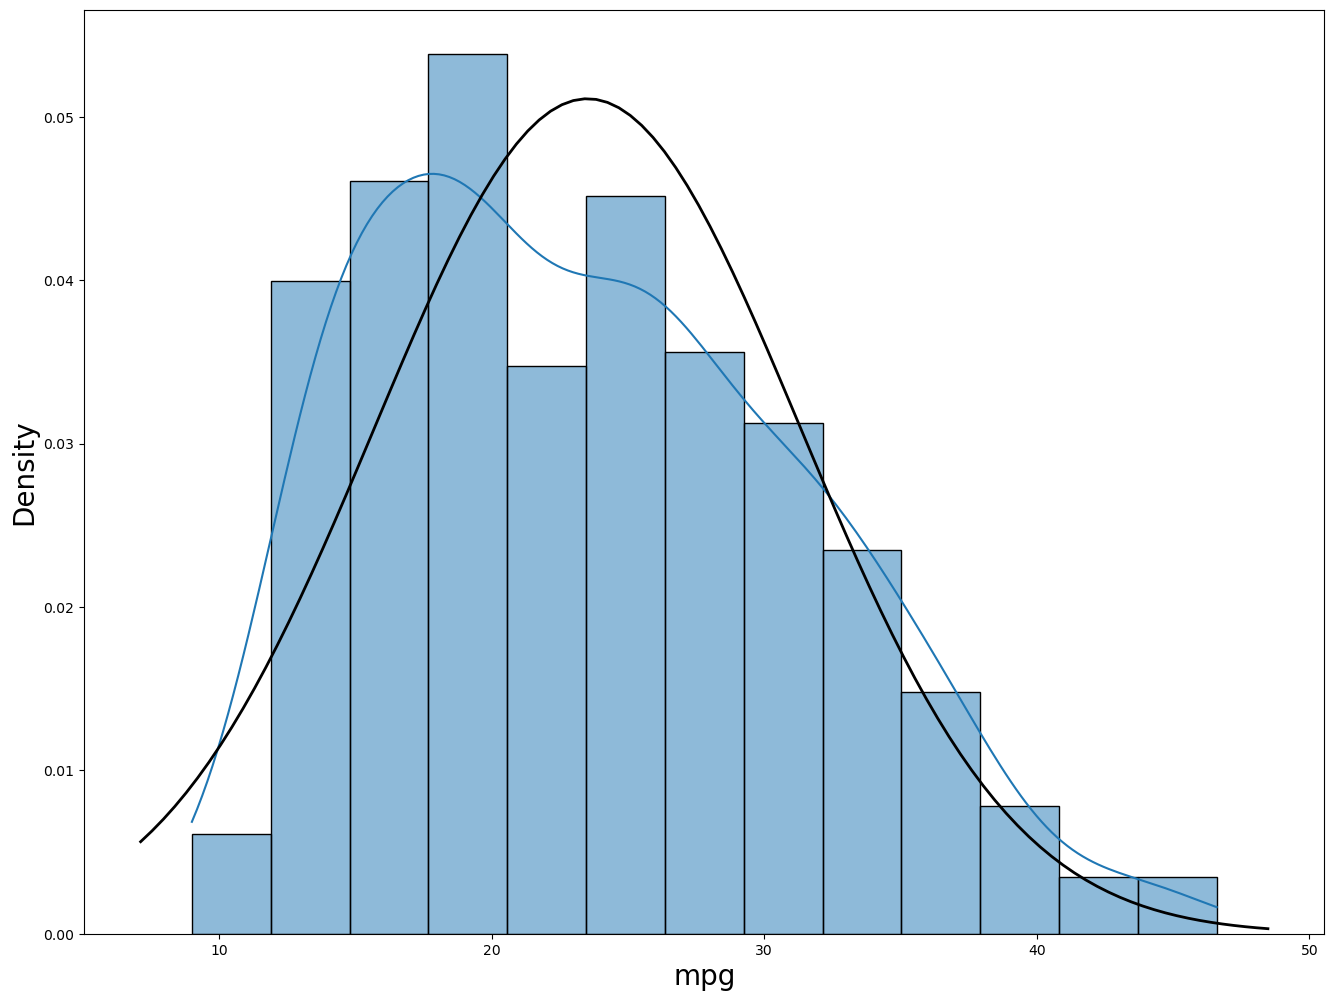

In [39]:
mu, std = plot_distplot(auto_df, 'mpg')

In [40]:
mu, std

(23.514572864321607, 7.806159061274433)

The dependent variable should be normally distributed so that models can provide better results. This can be done by applying the log1p transformation.

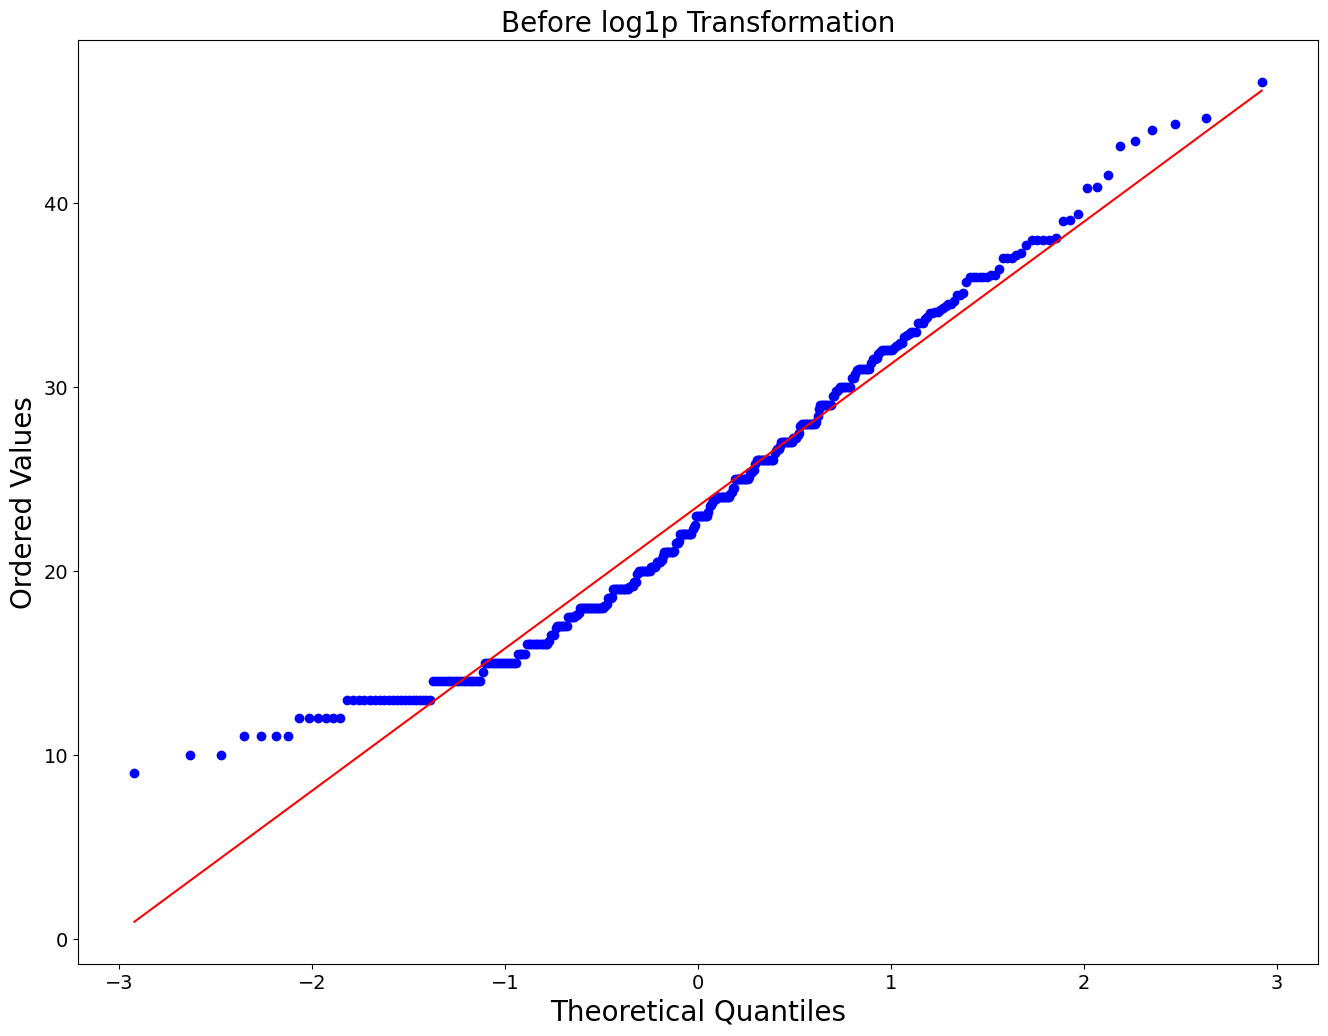

In [41]:
fig = plt.figure(figsize=(16, 12))
stats.probplot(auto_df['mpg'], plot=plt)
plt.xlabel('Theoretical Quantiles', fontsize=20)
plt.ylabel('Ordered Values', fontsize=20)
plt.title("Before log1p Transformation", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [42]:
auto_df['mpg'] = np.log1p(auto_df['mpg'])

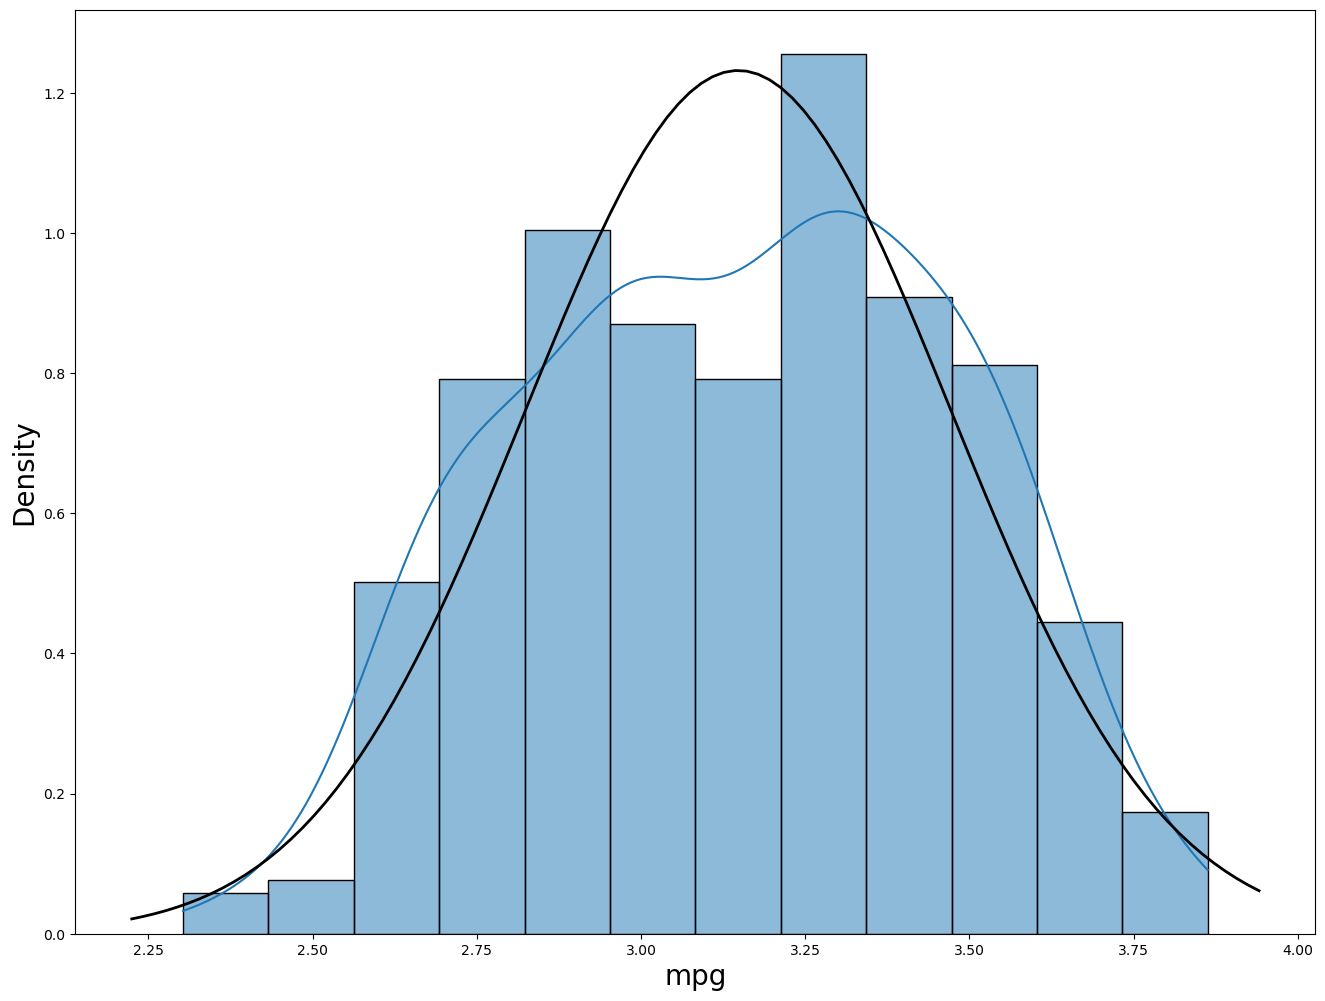

(3.1478302770344047, 0.32375928015327066)

In [43]:
plot_distplot(auto_df, 'mpg')

In [44]:
mu, std

(23.514572864321607, 7.806159061274433)

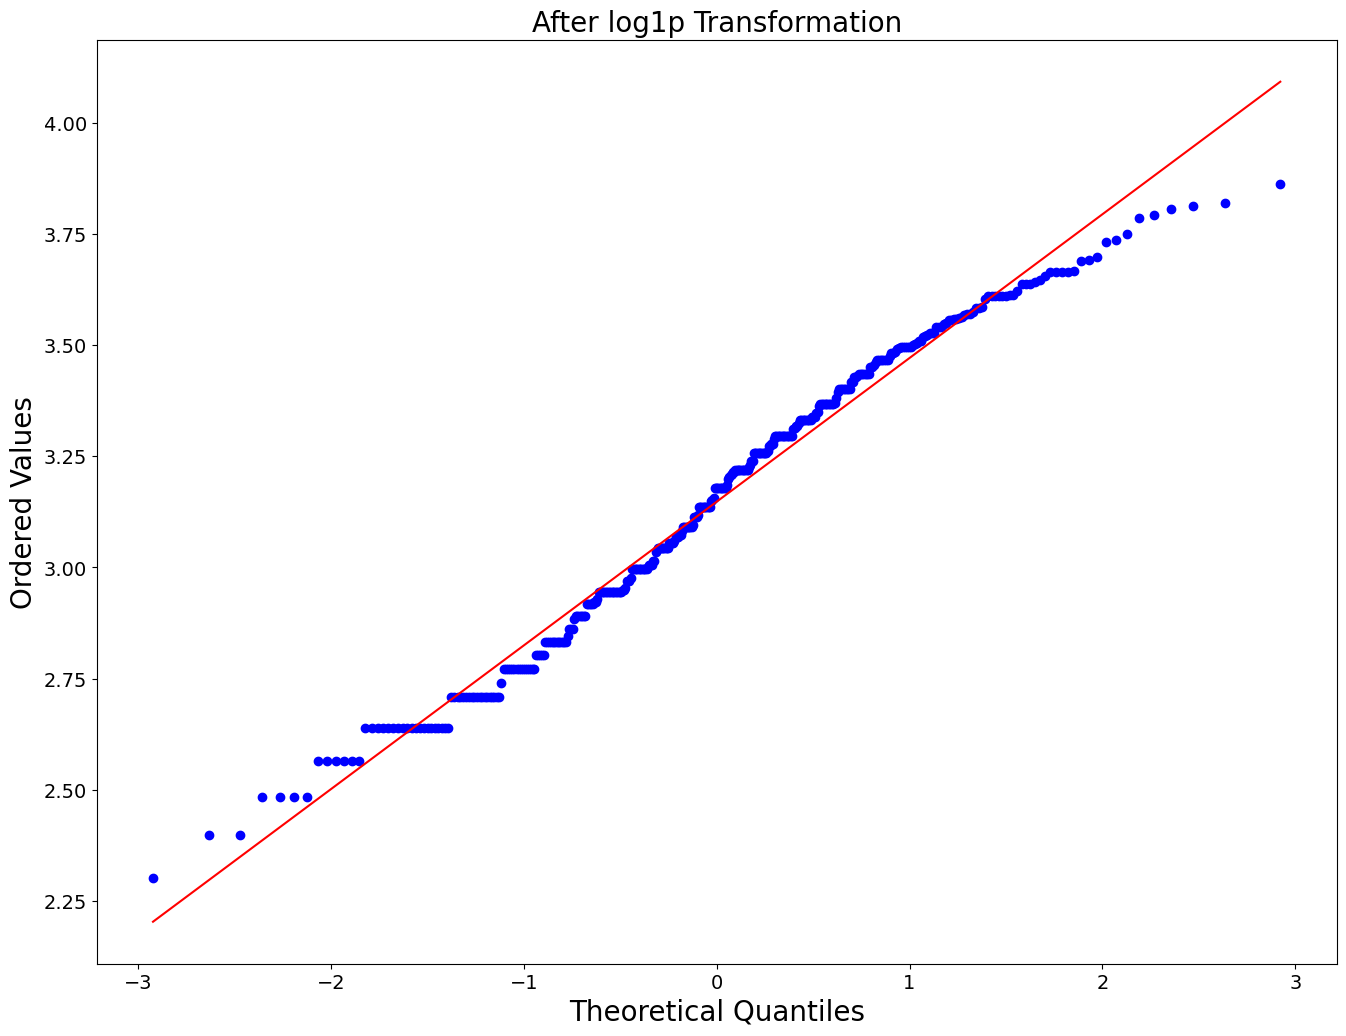

In [45]:
fig = plt.figure(figsize=(16, 12))
stats.probplot(auto_df['mpg'], plot=plt)
plt.xlabel('Theoretical Quantiles', fontsize=20)
plt.ylabel('Ordered Values', fontsize=20)
plt.title('After log1p Transformation', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### One Hot Encoding

In [46]:
auto_df = pd.get_dummies(auto_df, columns=['cylinders', 'origin', 'brand'])
auto_df

mpg  displacement  horsepower  weight  acceleration  model year  \
0    2.944439         307.0       130.0    3504          12.0          70   
1    2.772589         350.0       165.0    3693          11.5          70   
2    2.944439         318.0       150.0    3436          11.0          70   
3    2.833213         304.0       150.0    3433          12.0          70   
4    2.890372         302.0       140.0    3449          10.5          70   
..        ...           ...         ...     ...           ...         ...   
393  3.332205         140.0        86.0    2790          15.6          82   
394  3.806662          97.0        52.0    2130          24.6          82   
395  3.496508         135.0        84.0    2295          11.6          82   
396  3.367296         120.0        79.0    2625          18.6          82   
397  3.465736         119.0        82.0    2720          19.4          82   

                name  cylinders_3  cylinders_4  cylinders_5  ...  \
0    chevelle malibu            0            0            0  ...   
1        skylark 320            0            0            0  ...   
2          satellite            0            0            0  ...   
3          rebel sst            0            0            0  ...   
4             torino            0            0            0  ...   
..               ...          ...          ...          ...  ...   
393       mustang gl            0            1            0  ...   
394           pickup            0            1            0  ...   
395          rampage            0            1            0  ...   
396           ranger            0            1            0  ...   
397             s-10            0            1            0  ...   

     brand_peugeot  brand_plymouth  brand_pontiac  brand_renault  brand_saab  \
0                0               0              0              0           0   
1                0               0              0              0           0   
2                0               1              0              0           0   
3                0               0              0              0           0   
4                0               0              0              0           0   
..             ...             ...            ...            ...         ...   
393              0               0              0              0           0   
394              0               0              0              0           0   
395              0               0              0              0           0   
396              0               0              0              0           0   
397              0               0              0              0           0   

     brand_subaru  brand_toyota  brand_triumph  brand_volkswagen  brand_volvo  
0               0             0              0                 0            0  
1               0             0              0                 0            0  
2               0             0              0                 0            0  
3               0             0              0                 0            0  
4               0             0              0                 0            0  
..            ...           ...            ...               ...          ...  
393             0             0              0                 0            0  
394             0             0              0                 1            0  
395             0             0              0                 0            0  
396             0             0              0                 0            0  
397             0             0              0                 0            0  

[398 rows x 44 columns]

In [47]:
auto_df.nunique().sort_values(ascending=False)

weight                 351
name                   300
mpg                    129
acceleration            95
horsepower              93
displacement            82
model year              13
brand_peugeot            2
brand_honda              2
brand_mazda              2
brand_mercedes-benz      2
brand_mercury            2
brand_nissan             2
brand_oldsmobile         2
brand_opel               2
brand_renault            2
brand_plymouth           2
brand_pontiac            2
brand_ford               2
brand_saab               2
brand_subaru             2
brand_toyota             2
brand_triumph            2
brand_volkswagen         2
brand_harvester          2
brand_datsun             2
brand_fiat               2
brand_dodge              2
cylinders_3              2
cylinders_4              2
cylinders_5              2
cylinders_6              2
cylinders_8              2
origin_1                 2
origin_2                 2
origin_3                 2
brand_amc                2
b

In [48]:
[auto_df[column].value_counts(normalize=True) for column in auto_df.columns]

[2.639057    0.050251
 2.708050    0.047739
 2.944439    0.042714
 2.772589    0.040201
 3.295837    0.035176
               ...   
 3.493473    0.002513
 2.884801    0.002513
 2.954910    0.002513
 3.148453    0.002513
 3.806662    0.002513
 Name: mpg, Length: 129, dtype: float64,
 97.0     0.052764
 98.0     0.045226
 350.0    0.045226
 318.0    0.042714
 250.0    0.042714
            ...   
 104.0    0.002513
 110.0    0.002513
 130.0    0.002513
 111.0    0.002513
 144.0    0.002513
 Name: displacement, Length: 82, dtype: float64,
 150.0    0.055276
 90.0     0.050251
 88.0     0.047739
 110.0    0.045226
 100.0    0.045226
            ...   
 122.0    0.002513
 61.0     0.002513
 93.0     0.002513
 148.0    0.002513
 82.0     0.002513
 Name: horsepower, Length: 93, dtype: float64,
 1985    0.010050
 2130    0.010050
 2125    0.007538
 2945    0.007538
 2265    0.007538
           ...   
 2875    0.002513
 3102    0.002513
 3664    0.002513
 2807    0.002513
 2625    0.002513
 Name

In [49]:
useless_columns = [columns for columns in auto_df.columns if auto_df[columns].nunique() == 2 and (auto_df[columns].value_counts(normalize=True) < 0.03).any()]

print(f'Number of useless variables: {len(useless_columns)}')

auto_df.drop(useless_columns, axis=1, inplace=True)

Number of useless variables: 19


In [50]:
px.imshow(auto_df.corr(), color_continuous_scale='RdBu', text_auto=True).update_layout(width=950, height=950)

## Preprocessing

In [51]:
auto_df = auto_df.drop(['name'], axis=1)
auto_df

mpg  displacement  horsepower  weight  acceleration  model year  \
0    2.944439         307.0       130.0    3504          12.0          70   
1    2.772589         350.0       165.0    3693          11.5          70   
2    2.944439         318.0       150.0    3436          11.0          70   
3    2.833213         304.0       150.0    3433          12.0          70   
4    2.890372         302.0       140.0    3449          10.5          70   
..        ...           ...         ...     ...           ...         ...   
393  3.332205         140.0        86.0    2790          15.6          82   
394  3.806662          97.0        52.0    2130          24.6          82   
395  3.496508         135.0        84.0    2295          11.6          82   
396  3.367296         120.0        79.0    2625          18.6          82   
397  3.465736         119.0        82.0    2720          19.4          82   

     cylinders_4  cylinders_6  cylinders_8  origin_1  ...  brand_chevrolet  \
0              0            0            1         1  ...                1   
1              0            0            1         1  ...                0   
2              0            0            1         1  ...                0   
3              0            0            1         1  ...                0   
4              0            0            1         1  ...                0   
..           ...          ...          ...       ...  ...              ...   
393            1            0            0         1  ...                0   
394            1            0            0         0  ...                0   
395            1            0            0         1  ...                0   
396            1            0            0         1  ...                0   
397            1            0            0         1  ...                1   

     brand_datsun  brand_dodge  brand_ford  brand_honda  brand_mazda  \
0               0            0           0            0            0   
1               0            0           0            0            0   
2               0            0           0            0            0   
3               0            0           0            0            0   
4               0            0           1            0            0   
..            ...          ...         ...          ...          ...   
393             0            0           1            0            0   
394             0            0           0            0            0   
395             0            1           0            0            0   
396             0            0           1            0            0   
397             0            0           0            0            0   

     brand_plymouth  brand_pontiac  brand_toyota  brand_volkswagen  
0                 0              0             0                 0  
1                 0              0             0                 0  
2                 1              0             0                 0  
3                 0              0             0                 0  
4                 0              0             0                 0  
..              ...            ...           ...               ...  
393               0              0             0                 0  
394               0              0             0                 1  
395               0              0             0                 0  
396               0              0             0                 0  
397               0              0             0                 0  

[398 rows x 24 columns]

In [52]:
X = auto_df.drop(['mpg'], axis=1)
y = auto_df['mpg']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Building

In [55]:
models = []

### Linear Regression

In [56]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [57]:
lr.coef_

array([ 0.06838889, -0.09589237, -0.1880509 , -0.0091127 ,  0.10537542,
        0.05654596,  0.00293524,  0.02338428, -0.01884014,  0.02204489,
        0.00188494, -0.00678303,  0.00905602,  0.00086462,  0.02497767,
        0.00449372, -0.01069588,  0.00311836,  0.00356867,  0.01490651,
        0.01788229,  0.00348356, -0.00645842])

In [58]:
y_pred = lr.predict(X_test)

In [59]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.09971993173050589

In [60]:
r2 = r2_score(y_test, y_pred) 
r2

0.8989741507387514

In [61]:
models.append({
    'name': 'Linear Regression',
    'model': lr,
    'rmse': rmse,
    'r^2': r2
})

### Ridge Regression

In [62]:
alphas = np.logspace(-4, 1, 30)
param_grid = {'alpha': alphas}

ridge = Ridge(max_iter=10000, random_state=42)

grid_search = GridSearchCV(ridge,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   refit=True)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

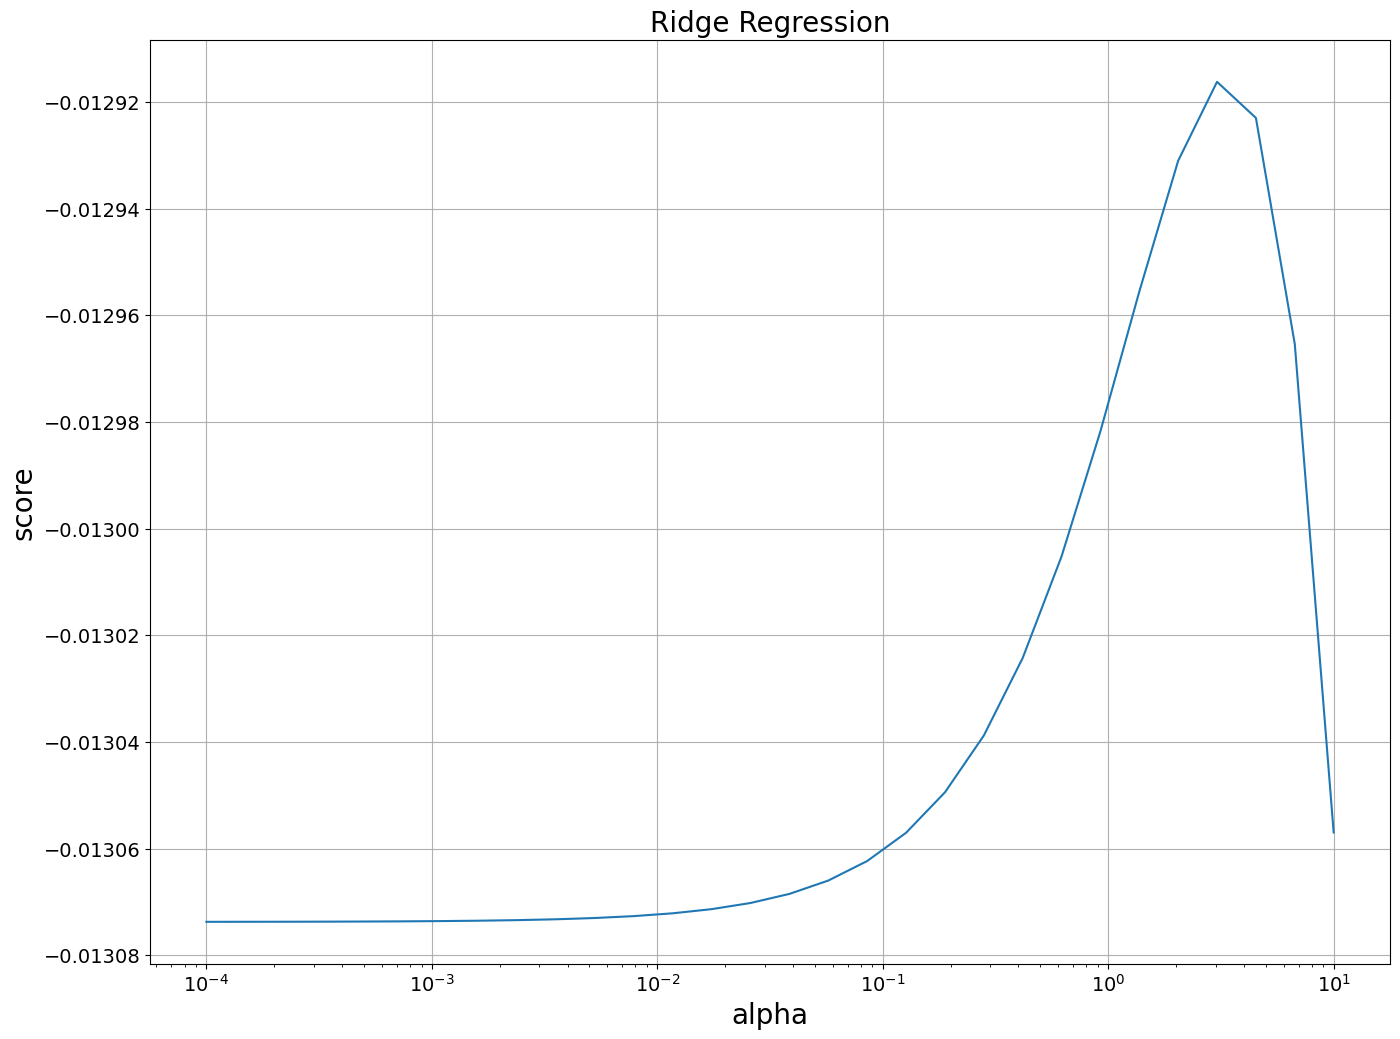

In [63]:
plt.figure(figsize=(16, 12))
plt.semilogx(alphas, scores)
plt.xlabel('alpha', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.title('Ridge Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

In [64]:
grid_search.best_estimator_.coef_

array([ 0.04446765, -0.09307988, -0.16959373, -0.01089901,  0.10288934,
        0.05112304, -0.00161113,  0.01898776, -0.01690045,  0.01795895,
        0.00339681, -0.00703015,  0.00837238, -0.00037368,  0.02286041,
        0.00316499, -0.01209231,  0.00273007,  0.00090301,  0.0133288 ,
        0.01699679,  0.00182673, -0.00386757])

In [65]:
grid_search.best_estimator_

Ridge(alpha=3.039195382313201, max_iter=10000, random_state=42)

In [66]:
y_pred = grid_search.predict(X_test)

In [67]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.09991805012250914

In [68]:
r2 = r2_score(y_test, y_pred) 
r2

0.8985723261301836

In [69]:
models.append({
    'name': 'Ridge Regression',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

### Lasso Regression

In [70]:
alphas = np.logspace(-4, -0.5, 30)
param_grid = {'alpha': alphas}

lasso = Lasso(max_iter=10000, random_state=42)

grid_search = GridSearchCV(lasso,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   refit=True)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

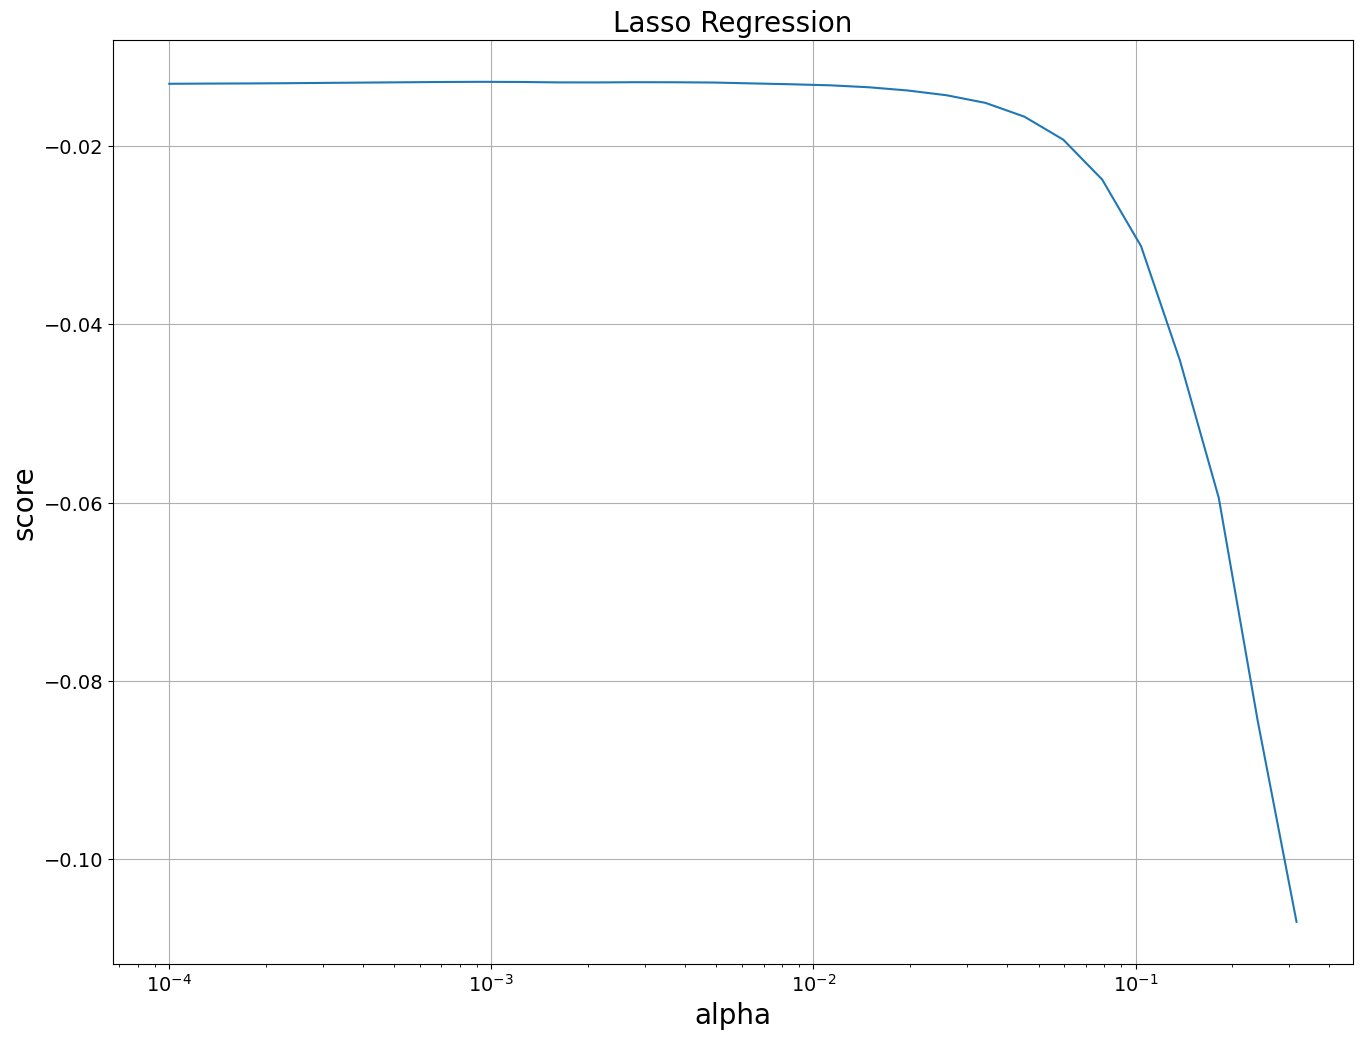

In [71]:
plt.figure(figsize=(16, 12))
plt.semilogx(alphas, scores)
plt.xlabel('alpha', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.title('Lasso Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

In [72]:
grid_search.best_estimator_.coef_

array([ 3.89801637e-02, -8.11032847e-02, -1.76816380e-01, -7.31265445e-03,
        1.03601507e-01,  4.61744721e-02, -3.09562468e-03,  1.59400289e-02,
       -1.93462644e-02,  1.08436523e-02,  0.00000000e+00, -7.99023061e-03,
        5.59935677e-03, -1.33886137e-03,  1.98962725e-02,  3.87964555e-04,
       -1.29196224e-02,  9.75834812e-04, -1.24597240e-04,  1.09556583e-02,
        1.52261271e-02,  0.00000000e+00, -1.83776254e-03])

In [73]:
grid_search.best_estimator_

Lasso(alpha=0.0009236708571873865, max_iter=10000, random_state=42)

In [74]:
y_pred = grid_search.predict(X_test)

In [75]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.09927672257536654

In [76]:
r2 = r2_score(y_test, y_pred) 
r2

0.8998701817950856

In [77]:
models.append({
    'name': 'Lasso Regression',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

### ElasticNet

In [78]:
param_grid = {
    'alpha': np.logspace(-4, -0.5, 30),
    'l1_ratio': np.arange(0.0, 1.0, 0.05)
}

enet = ElasticNet(max_iter=10000, random_state=42)

grid_search = GridSearchCV(enet,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   refit=True)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

In [79]:
grid_search.best_estimator_.coef_

array([ 0.03822439, -0.08214813, -0.17510913, -0.00777229,  0.10338922,
        0.04643755, -0.00312702,  0.01604942, -0.01956007,  0.01082942,
        0.        , -0.00792144,  0.00580435, -0.00132306,  0.02000323,
        0.00055178, -0.01293257,  0.00107275, -0.00018076,  0.01106545,
        0.01532367,  0.        , -0.00187829])

In [80]:
grid_search.best_estimator_

ElasticNet(alpha=0.0021261123338996556, l1_ratio=0.4, max_iter=10000,
           random_state=42)

In [81]:
y_pred = grid_search.predict(X_test)

In [82]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.09934841510445751

In [83]:
r2 = r2_score(y_test, y_pred) 
r2

0.8997255123960338

In [84]:
models.append({
    'name': 'ElasticNet',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

### KNN Regression

In [85]:
n_neighbors = list(range(1, 11))
param_grid = {'n_neighbors': n_neighbors}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(knn,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   return_train_score=False
                   )
  
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

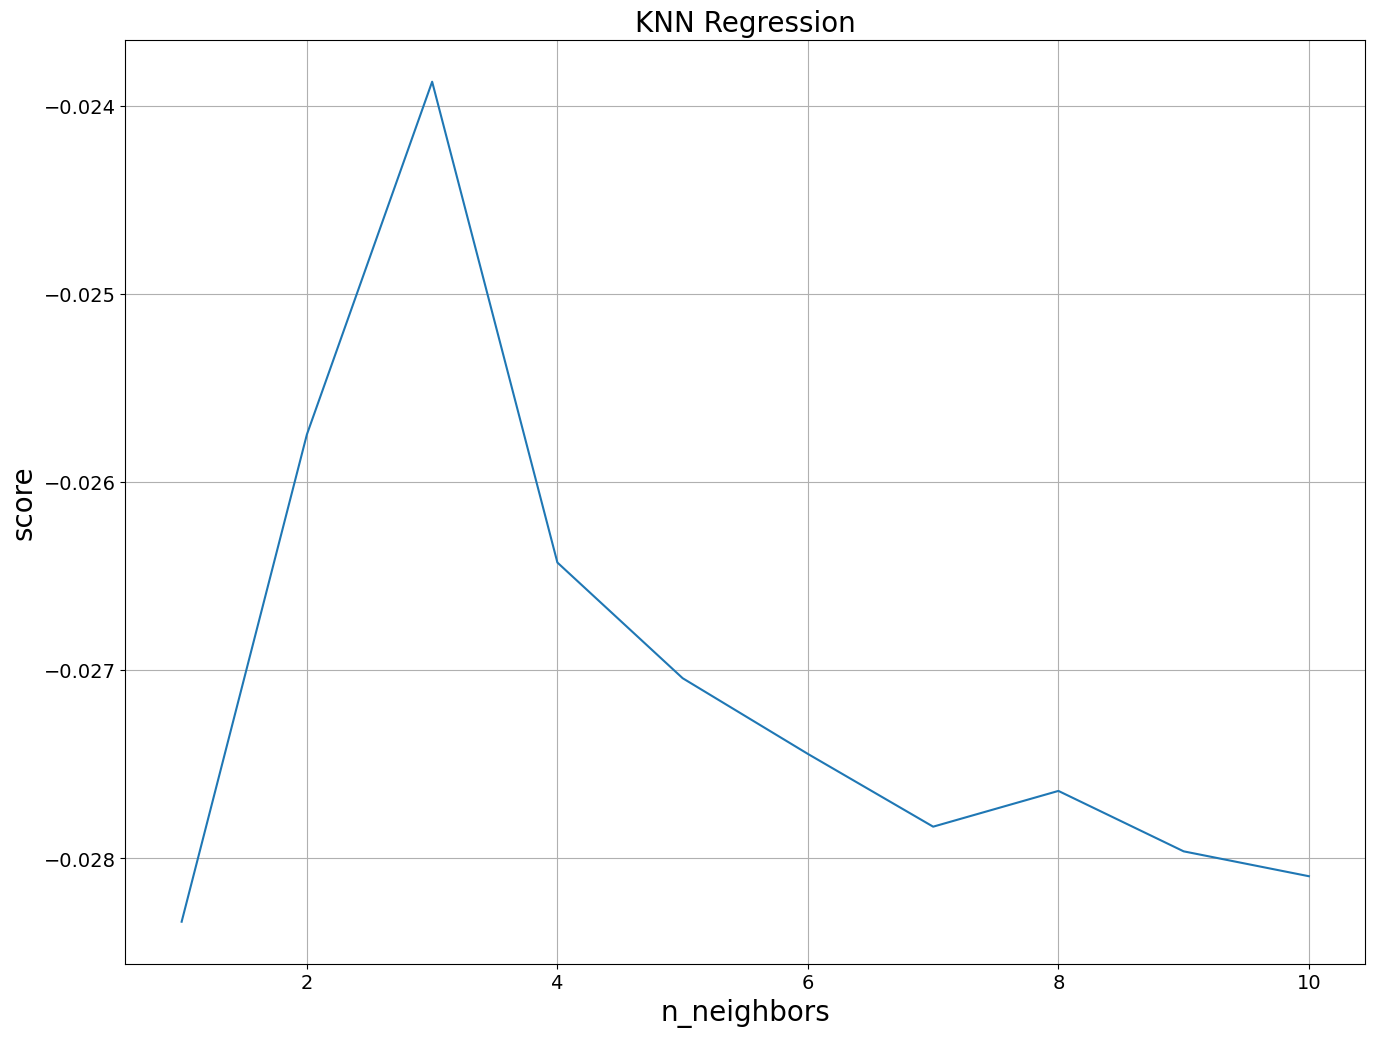

In [86]:
plt.figure(figsize=(16, 12))
plt.plot(n_neighbors, scores)
plt.xlabel('n_neighbors', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.title('KNN Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

In [87]:
grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=3)

In [88]:
y_pred = grid_search.predict(X_test)

In [89]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.10912761897911849

In [90]:
r2 = r2_score(y_test, y_pred) 
r2

0.8790132184005041

In [91]:
models.append({
    'name': 'KNN Regression',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

### Decision Tree Regression

In [92]:
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, None],
    'max_features': [2, 4, 8, 16, 32, None],
    'splitter': ['best', 'random'],
}

tree_reg = DecisionTreeRegressor()

grid_search = GridSearchCV(tree_reg,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   return_train_score=False
                   )
  
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

In [93]:
grid_search.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=6,
                      splitter='random')

In [94]:
y_pred = grid_search.predict(X_test)

In [95]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.10945413217045122

In [96]:
r2 = r2_score(y_test, y_pred) 
r2

0.8782881429557783

In [97]:
models.append({
    'name': 'Decision Tree Regression',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

### Random Forest Regression

In [98]:
n_estimators = [100, 200, 300, 500, 1000, 5000, 10000]
param_grid = {'n_estimators': n_estimators}


forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   return_train_score=False,
                   )
  
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

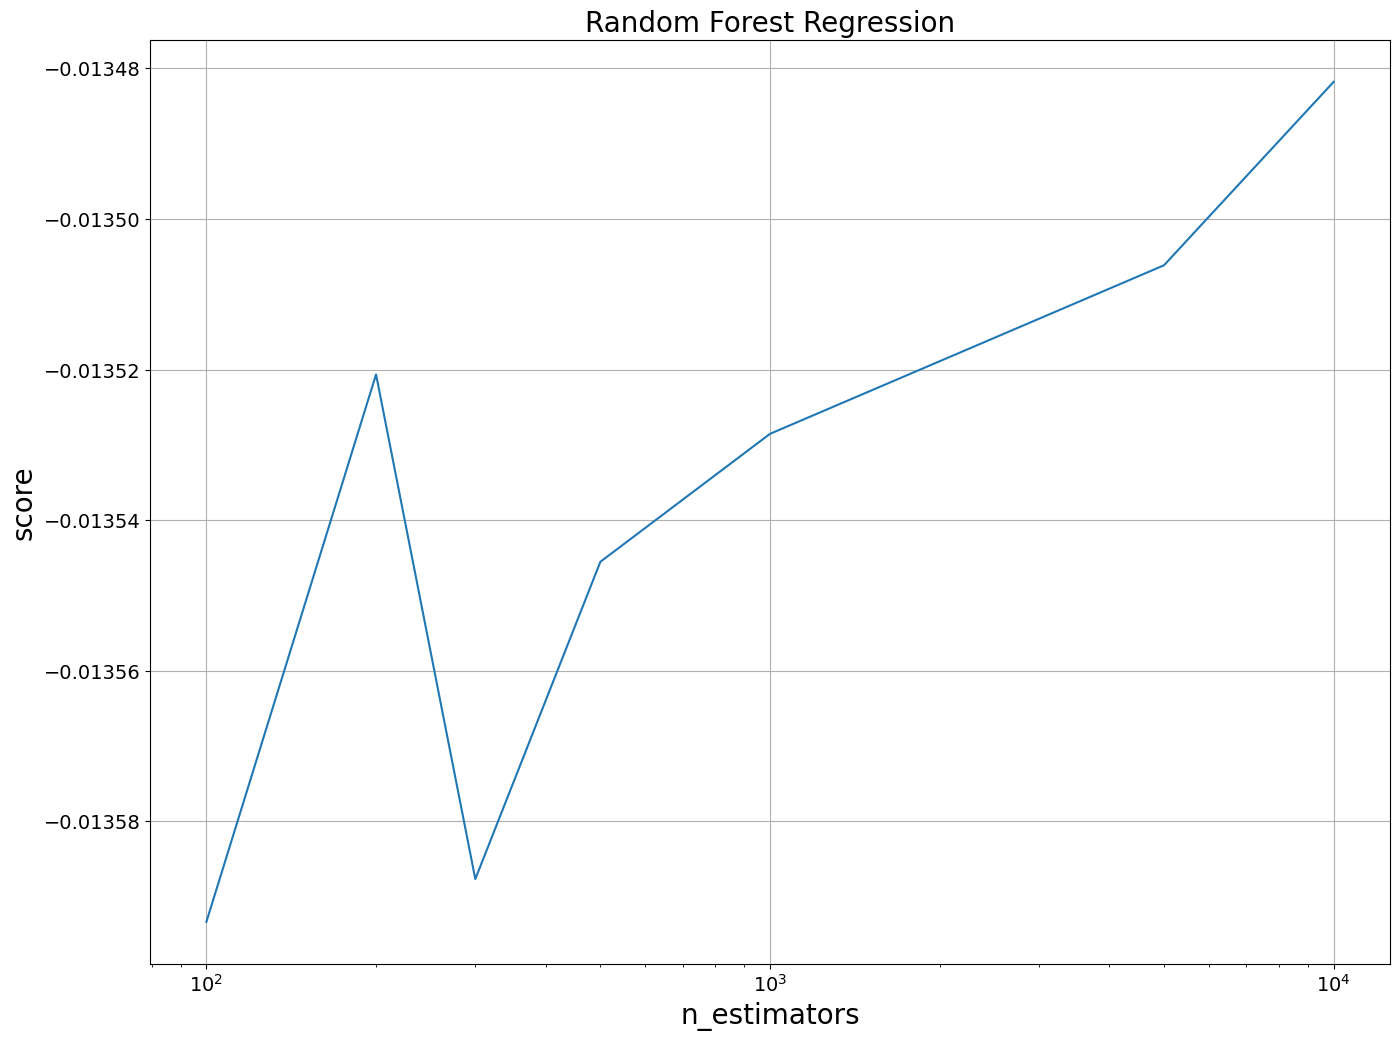

In [99]:
plt.figure(figsize=(16, 12))
plt.semilogx(n_estimators, scores)
plt.xlabel('n_estimators', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.title('Random Forest Regression', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

In [100]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=10000)

In [101]:
y_pred = grid_search.predict(X_test)

In [102]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.08938675805050231

In [103]:
r2 = r2_score(y_test, y_pred) 
r2

0.9188263756418789

In [104]:
models.append({
    'name': 'Random Forest Regression',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

### Support Vector Regression

In [105]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [1, 2, 4, 8, 16],
    'gamma': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

svm_reg = SVR()

grid_search = GridSearchCV(svm_reg,
                   param_grid,
                   cv=5,
                   scoring='neg_mean_squared_error',
                   return_train_score=False,
                   )
  
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
scores_std = grid_search.cv_results_['std_test_score']

In [106]:
grid_search.best_estimator_

SVR(C=16, gamma=0.001)

In [107]:
y_pred = grid_search.predict(X_test)

In [108]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.09499206897627847

In [109]:
r2 = r2_score(y_test, y_pred)

In [110]:
models.append({
    'name': 'Support Vector Regression',
    'model': grid_search.best_estimator_,
    'rmse': rmse,
    'r^2': r2
})

## Results

In [111]:
pd.DataFrame(models).set_index('name').sort_values(['rmse', 'r^2'], ascending=[True, False])

model  \
name                                                                           
Random Forest Regression   (DecisionTreeRegressor(max_features=1.0, rando...   
Support Vector Regression                             SVR(C=16, gamma=0.001)   
Lasso Regression           Lasso(alpha=0.0009236708571873865, max_iter=10...   
ElasticNet                 ElasticNet(alpha=0.0021261123338996556, l1_rat...   
Linear Regression                                         LinearRegression()   
Ridge Regression           Ridge(alpha=3.039195382313201, max_iter=10000,...   
KNN Regression                            KNeighborsRegressor(n_neighbors=3)   
Decision Tree Regression   DecisionTreeRegressor(criterion='absolute_erro...   

                               rmse       r^2  
name                                           
Random Forest Regression   0.089387  0.918826  
Support Vector Regression  0.094992  0.908327  
Lasso Regression           0.099277  0.899870  
ElasticNet                 0.099348  0.899726  
Linear Regression          0.099720  0.898974  
Ridge Regression           0.099918  0.898572  
KNN Regression             0.109128  0.879013  
Decision Tree Regression   0.109454  0.878288

**Random Forest Regression** gives the best results on the test data set, having the lowest root mean squared error of **0.09** and the highest R squared score of **0.92**.